In [1]:
import requests
from io import BytesIO, StringIO
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import joblib
np.random.seed(0)

In [2]:
TF_MODEL_FNAME = 'tf-clf-wine'
RFC_FNAME = 'rfc-wine'
ENC_FNAME = 'wine_encoder'
DEC_FNAME = 'wine_decoder'

In [3]:
def fetch_wine_ds():
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
    resp = requests.get(url)
    string_io = StringIO(resp.content.decode('utf-8'))
    return pd.read_csv(string_io, sep=';')

In [4]:
df = fetch_wine_ds()
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [6]:
df['class'] = 'bad'
df.loc[(df['quality'] > 5), 'class'] = 'good'
features = [
'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
'pH', 'sulphates', 'alcohol']
df['good'] = 0
df['bad'] = 0
df.loc[df['class'] == 'good', 'good'] = 1
df.loc[df['class'] == 'bad', 'bad'] = 1
data = df[features].to_numpy()
labels = df[['class','good', 'bad']].to_numpy()
print(data[:5])
print(labels[:5])
X_train, X_test, y_train, y_test = train_test_split(data, labels, random_state=0)
X_train, X_test = X_train.astype('float32'), X_test.astype('float32')
y_train_lab, y_test_lab = y_train[:, 0], y_test[:, 0]
print(y_train_lab[:5])
y_train, y_test = y_train[:, 1:].astype('float32'), y_test[:, 1:].astype('float32')
scaler = StandardScaler()
scaler.fit(X_train)

[[7.400e+00 7.000e-01 0.000e+00 1.900e+00 7.600e-02 1.100e+01 3.400e+01
  9.978e-01 3.510e+00 5.600e-01 9.400e+00]
 [7.800e+00 8.800e-01 0.000e+00 2.600e+00 9.800e-02 2.500e+01 6.700e+01
  9.968e-01 3.200e+00 6.800e-01 9.800e+00]
 [7.800e+00 7.600e-01 4.000e-02 2.300e+00 9.200e-02 1.500e+01 5.400e+01
  9.970e-01 3.260e+00 6.500e-01 9.800e+00]
 [1.120e+01 2.800e-01 5.600e-01 1.900e+00 7.500e-02 1.700e+01 6.000e+01
  9.980e-01 3.160e+00 5.800e-01 9.800e+00]
 [7.400e+00 7.000e-01 0.000e+00 1.900e+00 7.600e-02 1.100e+01 3.400e+01
  9.978e-01 3.510e+00 5.600e-01 9.400e+00]]
[['bad' 0 1]
 ['bad' 0 1]
 ['bad' 0 1]
 ['good' 1 0]
 ['bad' 0 1]]
['bad' 'bad' 'bad' 'good' 'bad']


StandardScaler()

In [6]:
bad_wines = np.array([a for a, b in zip(X_train, y_train) if b[1] == 1])
good_wines = np.array([a for a, b in zip(X_train, y_train) if b[1] == 0])
x = np.array([[9.2, 0.36, 0.34, 1.6, 0.062, 5., 12., 0.99667, 3.2, 0.67, 10.5]]) 
#prechosen instance
print(bad_wines.shape)
print(good_wines.shape)


(559, 11)
(640, 11)


In [7]:
import tensorflow.keras as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, Sequential,load_model
ENCODING_DIM = 7
BATCH_SIZE = 64
EPOCHS = 100
class AE(tf.Model):
    def __init__(self, encoder: tf.Model, decoder: tf.Model, **kwargs) -> None:
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, x,**kwargs):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

def make_ae():
    len_input_output = X_train.shape[-1]
    encoder = Sequential()
    encoder.add(Dense(units=ENCODING_DIM*2, activation="relu", input_shape=(len_input_output, )))
    encoder.add(Dense(units=ENCODING_DIM, activation="relu"))
    
    decoder = Sequential()
    decoder.add(Dense(units=ENCODING_DIM*2, activation="relu", input_shape=(ENCODING_DIM,)))
    decoder.add(Dense(units=len_input_output, activation="linear"))
    ae = AE(encoder=encoder, decoder=decoder)
    ae.compile(optimizer='adam', loss='mean_squared_error')
    history = ae.fit(scaler.transform(X_train),scaler.transform(X_train),
                     batch_size=BATCH_SIZE,epochs=EPOCHS,verbose=False,)
    # loss = history.history['loss']
    # plt.plot(loss)
    # plt.xlabel('Epoch')
    # plt.ylabel('MSE-Loss')
    ae.encoder.save(f'{ENC_FNAME}.h5')
    ae.decoder.save(f'{DEC_FNAME}.h5')
    return ae
def load_ae_model():
    encoder = load_model(f'{ENC_FNAME}.h5')
    decoder = load_model(f'{DEC_FNAME}.h5')
    return AE(encoder=encoder, decoder=decoder)

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

def make_rfc():
    rfc = RandomForestClassifier(n_estimators=50)
    rfc.fit(scaler.transform(X_train), y_train_lab)
    y_pred = rfc.predict(scaler.transform(X_test))
    print('accuracy_score:', accuracy_score(y_pred, y_test_lab))
    print('f1_score:', f1_score(y_test_lab, y_pred, average=None))
    joblib.dump(rfc, f"{RFC_FNAME}.joblib")
    return rfc

def load_rfc_model():
    return joblib.load(f"{RFC_FNAME}.joblib")

In [9]:
def make_tf_model():
    inputs = Input(shape=X_train.shape[1])
    x = Dense(6, activation="relu")(inputs)
    outputs = Dense(2, activation="softmax")(x)
    model = Model(inputs, outputs)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])
    history = model.fit(scaler.transform(X_train),y_train,epochs=30,verbose=False,
                        validation_data=(scaler.transform(X_test), y_test),)
    y_pred = model(scaler.transform(X_test)).numpy().argmax(axis=1)
    print('accuracy_score:', accuracy_score(y_pred, y_test.argmax(axis=1)))
    print('f1_score:', f1_score(y_pred, y_test.argmax(axis=1), average=None))
    model.save(f'{TF_MODEL_FNAME}.h5')
    return model

def load_tf_model():
    return load_model(f'{TF_MODEL_FNAME}.h5')

In [10]:
rfc = make_rfc()
model = make_tf_model()
ae = make_ae()

accuracy_score: 0.815
f1_score: [0.8        0.82790698]
accuracy_score: 0.755
f1_score: [0.77314815 0.73369565]


In [11]:
def compare_instances(x, cf):
    """
    Show the difference in values between two instances.
    """
    x = x.astype('float64')
    cf = cf.astype('float64')
    for f, v1, v2 in zip(features, x[0], cf[0]):#<왼쪽 25개자리, ^가운데 10자리, >20: 오른쪽 20자리
        print(f'{f:<25} instance: {round(v1, 3):^10} counter factual: {round(v2, 3):^10} difference: {round(v2 - v1, 5):^5}')
        
def plot_importance(feat_imp, feat_names, class_idx, **kwargs):
    """
    Create a horizontal barchart of feature effects, sorted by their magnitude.
    """
    df = pd.DataFrame(data=feat_imp, columns=feat_names).sort_values(by=0, axis='columns')#0값을 기준점
    feat_imp, feat_names = df.values[0], df.columns
    fig, ax = plt.subplots(figsize=(10, 5))
    y_pos = np.arange(len(feat_imp))
    ax.barh(y_pos, feat_imp)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(feat_names, fontsize=15)
    ax.invert_yaxis()
    ax.set_xlabel(f'Feature effects for class {class_idx}', fontsize=15)
    return ax, fig

(<AxesSubplot: xlabel='Feature effects for class "good"'>,
 <Figure size 1000x500 with 1 Axes>)

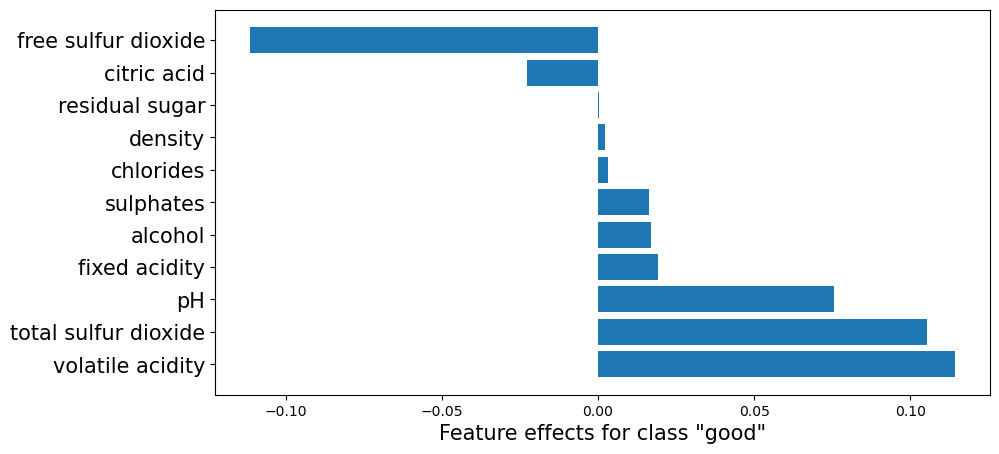

In [12]:
from alibi.explainers import IntegratedGradients
ig = IntegratedGradients(model,layer=None,method="gausslegendre",n_steps=50,internal_batch_size=100)
result = ig.explain(scaler.transform(x), target=0)
plot_importance(result.data['attributions'][0], features, '"good"')

  0%|          | 0/1 [00:00<?, ?it/s]

(<AxesSubplot: xlabel='Feature effects for class 1'>,
 <Figure size 1000x500 with 1 Axes>)

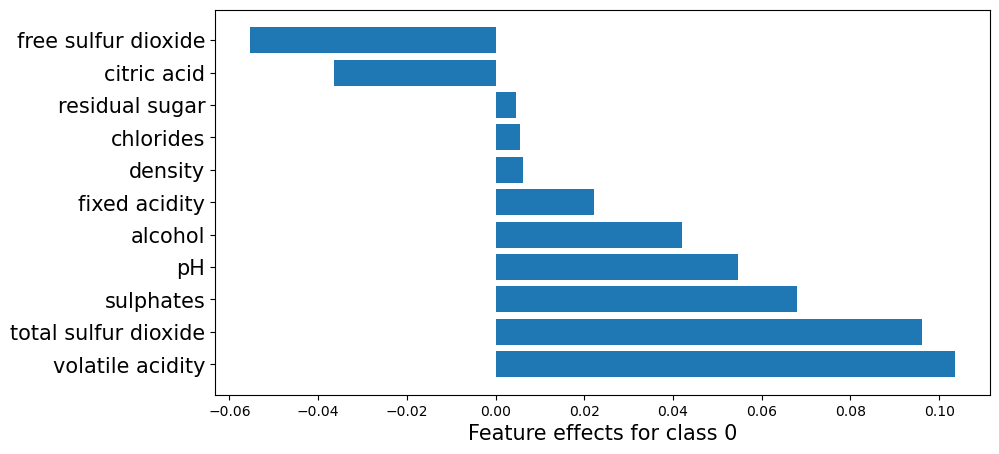

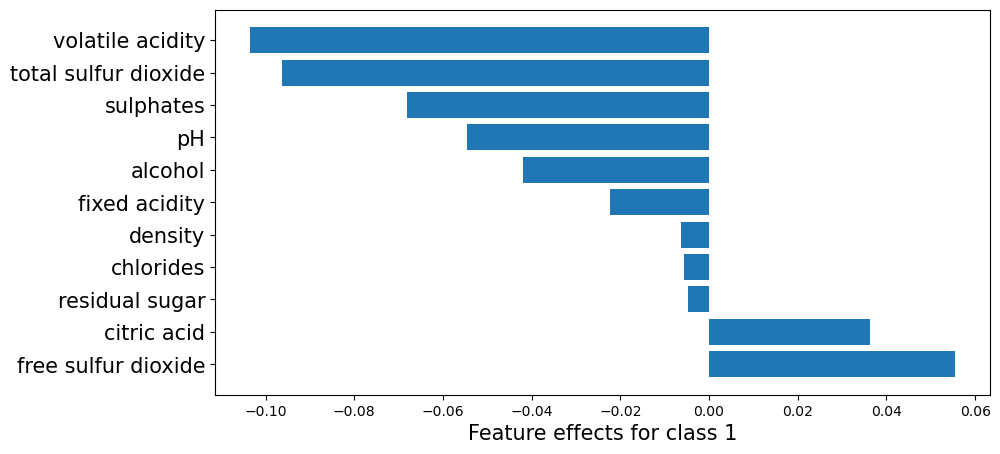

In [13]:
from alibi.explainers import KernelShap
predict_fn = lambda x: model(scaler.transform(x))
explainer = KernelShap(predict_fn, task='classification')
explainer.fit(X_train[0:100])
result = explainer.explain(x)
plot_importance(result.shap_values[0], features, 0)
plot_importance(result.shap_values[1], features, 1)

(<AxesSubplot: xlabel='Feature effects for class "Good"'>,
 <Figure size 1000x500 with 1 Axes>)

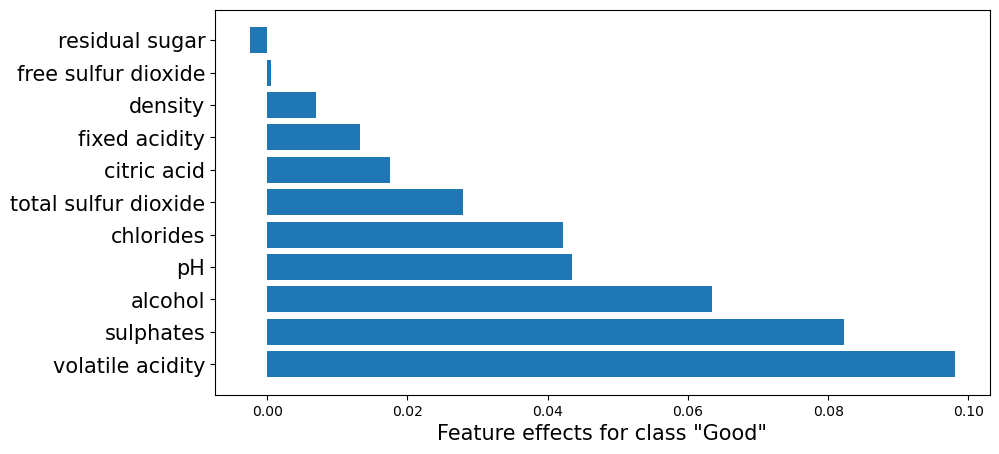

In [14]:
from alibi.explainers import TreeShap
tree_explainer_interventional = TreeShap(rfc, model_output='raw', task='classification')
tree_explainer_interventional.fit(scaler.transform(X_train[0:100]))
result = tree_explainer_interventional.explain(scaler.transform(x), check_additivity=False)
plot_importance(result.shap_values[1], features, '"Good"')

(<AxesSubplot: xlabel='Feature effects for class "Good"'>,
 <Figure size 1000x500 with 1 Axes>)

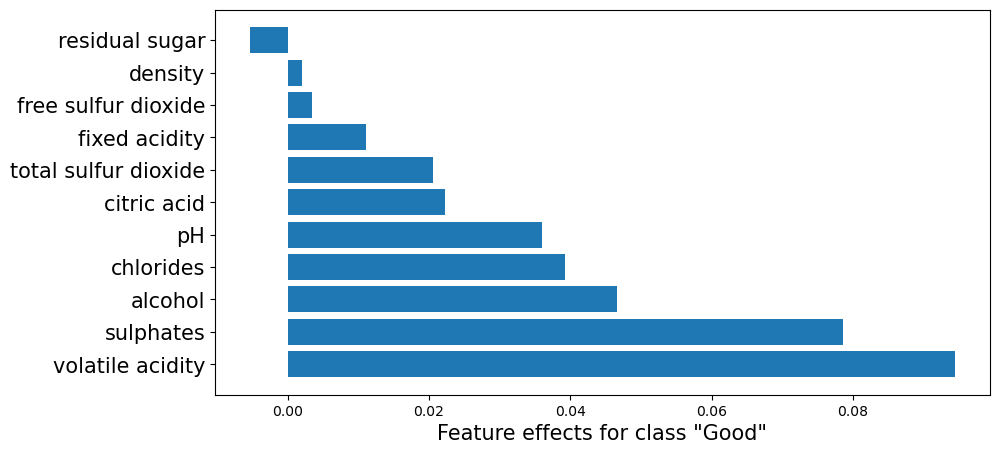

In [15]:
path_dependent_explainer = TreeShap(rfc, model_output='raw', task='classification')
path_dependent_explainer.fit()
result = path_dependent_explainer.explain(scaler.transform(x))
plot_importance(result.shap_values[1], features, '"Good"')

In [16]:
from alibi.explainers import AnchorTabular
predict_fn = lambda x: model.predict(scaler.transform(x))
explainer = AnchorTabular(predict_fn, features)
explainer.fit(X_train, disc_perc=(25, 50, 75))
result = explainer.explain(x, threshold=0.95)

4/4 [==============================] - 0s 2ms/step


In [17]:
print('Anchor =', result.data['anchor'])
print('Precision = ', result.data['precision'])
print('Coverage = ', result.data['coverage'])

Anchor = ['alcohol > 10.10', 'volatile acidity <= 0.39']
Precision =  0.9537313432835821
Coverage =  0.16263552960800667


array([[<AxesSubplot: xlabel='alcohol', ylabel='ALE'>]], dtype=object)

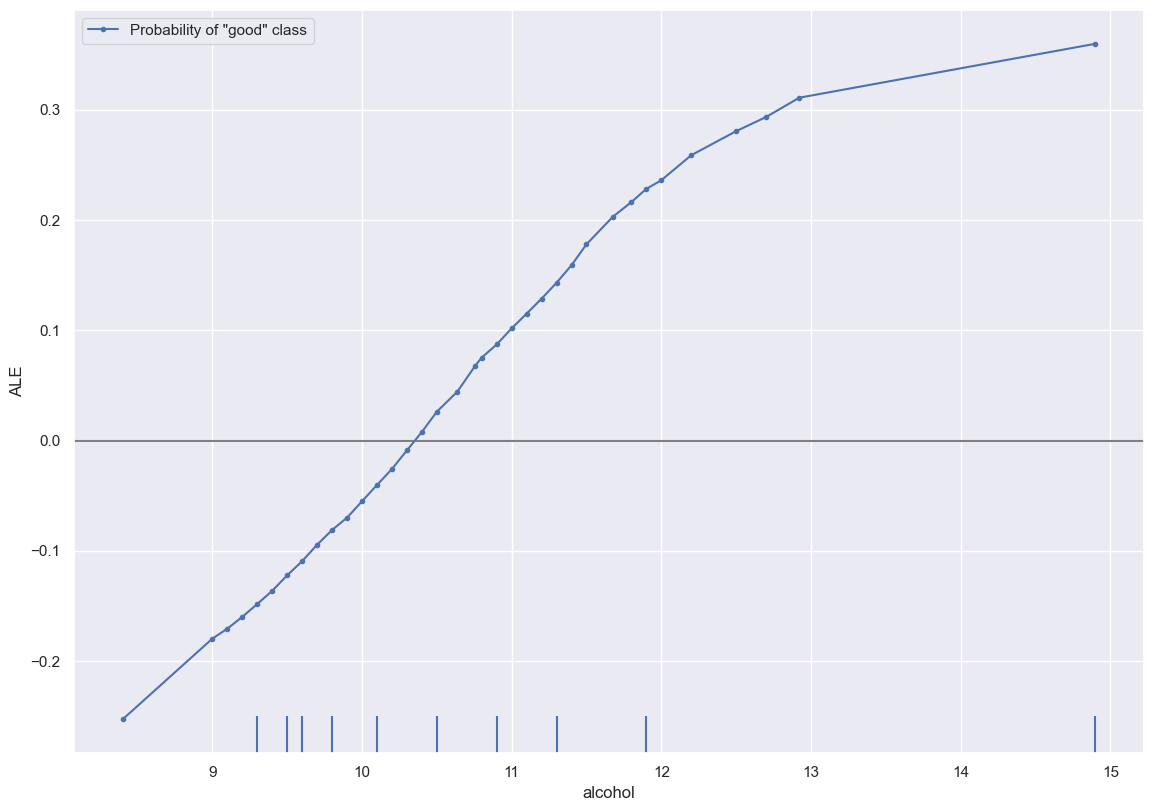

In [32]:
from alibi.explainers import ALE
from alibi.explainers.ale import plot_ale
predict_fn = lambda x: model(scaler.transform(x)).numpy()[:, 0]
ale = ALE(predict_fn, feature_names=features)
exp = ale.explain(X_train)
plot_ale(exp, features=['alcohol'], line_kw={'label': 'Probability of "good" class'})

array([[<AxesSubplot: xlabel='sulphates', ylabel='ALE'>,
        <AxesSubplot: xlabel='volatile acidity', ylabel='ALE'>,
        <AxesSubplot: xlabel='residual sugar', ylabel='ALE'>],
       [<AxesSubplot: xlabel='chlorides', ylabel='ALE'>,
        <AxesSubplot: xlabel='free sulfur dioxide', ylabel='ALE'>,
        <AxesSubplot: xlabel='total sulfur dioxide', ylabel='ALE'>]],
      dtype=object)

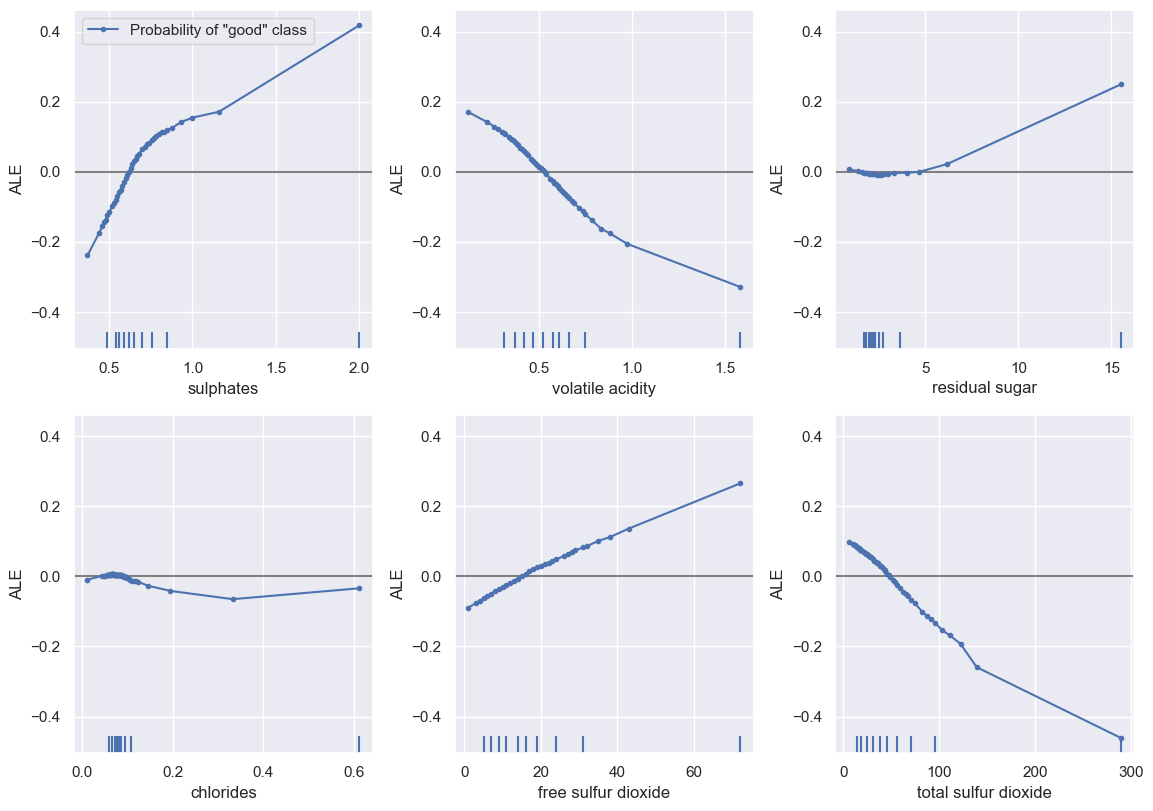

In [33]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
plot_ale(exp, features=['sulphates', 'volatile acidity', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide'], 
         line_kw={'label': 'Probability of "good" class'})

In [19]:
from alibi.explainers import CounterfactualRL
predict_fn = lambda x: model(x)
cfrl_explainer = CounterfactualRL(
predictor=predict_fn, # The model to explain
encoder=ae.encoder, # The encoder
decoder=ae.decoder, # The decoder
latent_dim=7, # The dimension of the autoencoder latent space
coeff_sparsity=0.5, # The coefficient of sparsity
coeff_consistency=0.5, # The coefficient of consistency
train_steps=10000, # The number of training steps
batch_size=100, # The batch size
)
cfrl_explainer.fit(X=scaler.transform(X_train))
result_cfrl = cfrl_explainer.explain(X=scaler.transform(x), Y_t=np.array([1]))
print("Instance class prediction:", model.predict(scaler.transform(x))[0].argmax())
print("Counterfactual class prediction:", model.predict(result_cfrl.data['cf']['X'])[0].argmax())

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 76.80it/s]


1/1 [==============================] - 0s 27ms/step
Instance class prediction: 0
1/1 [==============================] - 0s 29ms/step
Counterfactual class prediction: 1


In [20]:
cfrl = scaler.inverse_transform(result_cfrl.data['cf']['X'])
compare_instances(x, cfrl)

fixed acidity             instance:    9.2     counter factual:   8.746    difference: -0.45363
volatile acidity          instance:    0.36    counter factual:   0.364    difference: 0.00405
citric acid               instance:    0.34    counter factual:   0.328    difference: -0.01165
residual sugar            instance:    1.6     counter factual:   1.526    difference: -0.07394
chlorides                 instance:   0.062    counter factual:   0.075    difference: 0.01312
free sulfur dioxide       instance:    5.0     counter factual:   5.224    difference: 0.22355
total sulfur dioxide      instance:    12.0    counter factual:   23.771   difference: 11.7705
density                   instance:   0.997    counter factual:   0.997    difference: 0.00062
pH                        instance:    3.2     counter factual:   3.266    difference: 0.06616
sulphates                 instance:    0.67    counter factual:   0.612    difference: -0.05816
alcohol                   instance:    10.5   

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(<AxesSubplot: xlabel='Feature effects for class bad'>,
 <Figure size 1000x500 with 1 Axes>)

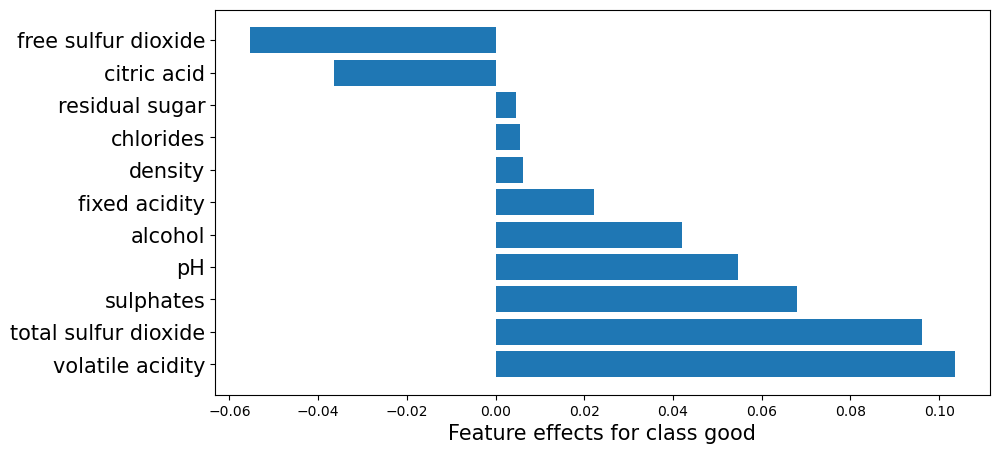

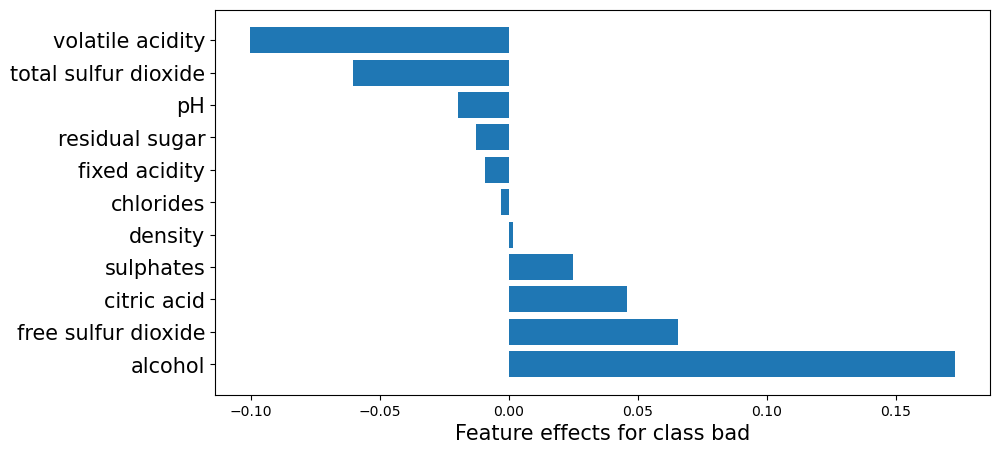

In [27]:
from alibi.explainers import KernelShap
predict_fn = lambda x: model(scaler.transform(x))
explainer = KernelShap(predict_fn, task='classification')
explainer.fit(X_train[0:100])
result_x = explainer.explain(x)
#print(result_x)
result_cfrl = explainer.explain(cfrl)
#print(result_cfrl)
plot_importance(result_x.shap_values[0], features, "good")
plot_importance(result_cfrl.shap_values[1], features, "bad")

First we need to revert to using tfv1

In [34]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [35]:
from tensorflow.keras.models import Model, load_model
model = load_tf_model()
ae = load_ae_model()

In [36]:
from alibi.explainers import Counterfactual
explainer = Counterfactual(
model, # The model to explain
shape=(1,) + X_train.shape[1:], # The shape of the model input
target_proba=0.51, # The target class probability
tol=0.01, # The tolerance for the loss
target_class='other', # The target class to obtain
)
result_cf = explainer.explain(scaler.transform(x))
print("Instance class prediction:", model.predict(scaler.transform(x))[0].argmax())
print("Counterfactual class prediction:", model.predict(result_cf.data['cf']['X'])[0].argmax())

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Instance class prediction: 0
Counterfactual class prediction: 1


In [37]:
cf = scaler.inverse_transform(result_cf.data['cf']['X'])
compare_instances(x, cf)

fixed acidity             instance:    9.2     counter factual:   9.231    difference: 0.03061
volatile acidity          instance:    0.36    counter factual:    0.36    difference: 0.00023
citric acid               instance:    0.34    counter factual:   0.341    difference: 0.00073
residual sugar            instance:    1.6     counter factual:   1.598    difference: -0.00225
chlorides                 instance:   0.062    counter factual:   0.062    difference: -0.00014
free sulfur dioxide       instance:    5.0     counter factual:   4.923    difference: -0.07704
total sulfur dioxide      instance:    12.0    counter factual:   12.666   difference: 0.66649
density                   instance:   0.997    counter factual:   0.997    difference: 1e-05
pH                        instance:    3.2     counter factual:    3.2     difference: -0.00022
sulphates                 instance:    0.67    counter factual:   0.489    difference: -0.18137
alcohol                   instance:    10.5    

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(<AxesSubplot: xlabel='Feature effects for class 1'>,
 <Figure size 1000x500 with 1 Axes>)

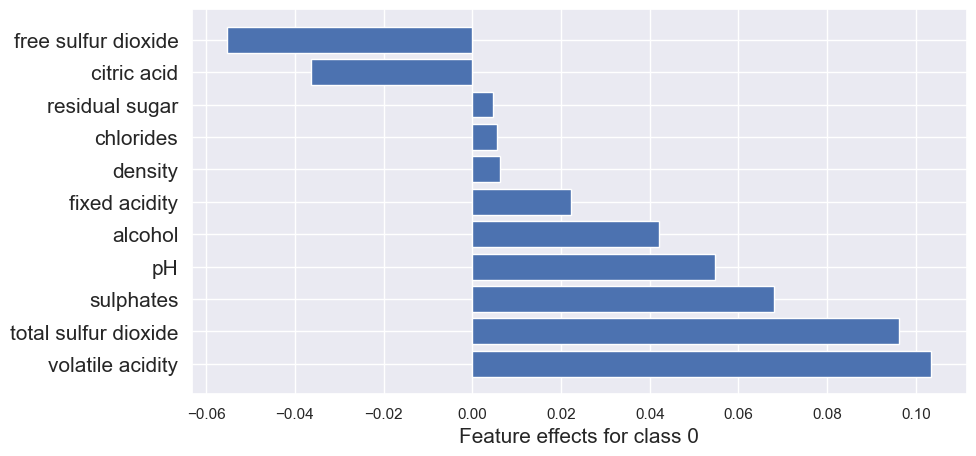

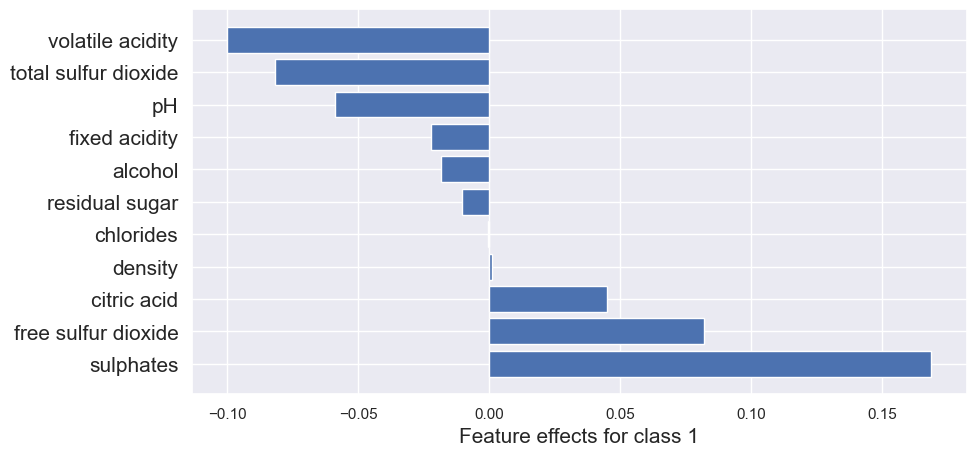

In [38]:
from alibi.explainers import KernelShap
predict_fn = lambda x: model.predict(scaler.transform(x))
explainer = KernelShap(predict_fn, task='classification')
explainer.fit(X_train[0:100])
result_x = explainer.explain(x)
result_cf = explainer.explain(cf)
plot_importance(result_x.shap_values[0], features, 0)
plot_importance(result_cf.shap_values[1], features, 1)

In [39]:
from alibi.explainers import CEM
cem = CEM(model, # model to explain
shape=(1,) + X_train.shape[1:], # shape of the model input
mode='PN', # pertinant negative mode
kappa=0.2, # Confidence parameter for the attack loss␣term
beta=0.1, # Regularization constant for L1 loss term
ae_model=ae # autoencoder model
)

cem.fit(
scaler.transform(X_train), # scaled training data
no_info_type='median' # non-informative value for each feature
)
result_cem = cem.explain(scaler.transform(x), verbose=False)
cem_cf = result_cem.data['PN']
print("Instance class prediction:", model.predict(scaler.transform(x))[0].argmax())
print("Counterfactual class prediction:", model.predict(cem_cf)[0].argmax())

Instance class prediction: 0
Counterfactual class prediction: 1


In [40]:
cem_cf = result_cem.data['PN']
cem_cf = scaler.inverse_transform(cem_cf)
compare_instances(x, cem_cf)

fixed acidity             instance:    9.2     counter factual:    9.2     difference: -0.0 
volatile acidity          instance:    0.36    counter factual:    0.36    difference:  0.0 
citric acid               instance:    0.34    counter factual:   0.439    difference: 0.0991
residual sugar            instance:    1.6     counter factual:    1.6     difference: -0.0 
chlorides                 instance:   0.062    counter factual:   0.062    difference: -0.0 
free sulfur dioxide       instance:    5.0     counter factual:  -13.779   difference: -18.77943
total sulfur dioxide      instance:    12.0    counter factual:    12.0    difference: -0.0 
density                   instance:   0.997    counter factual:   0.997    difference:  0.0 
pH                        instance:    3.2     counter factual:    3.2     difference:  0.0 
sulphates                 instance:    0.67    counter factual:   0.569    difference: -0.10138
alcohol                   instance:    10.5    counter factual

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

(<AxesSubplot: xlabel='Feature effects for class 1'>,
 <Figure size 1000x500 with 1 Axes>)

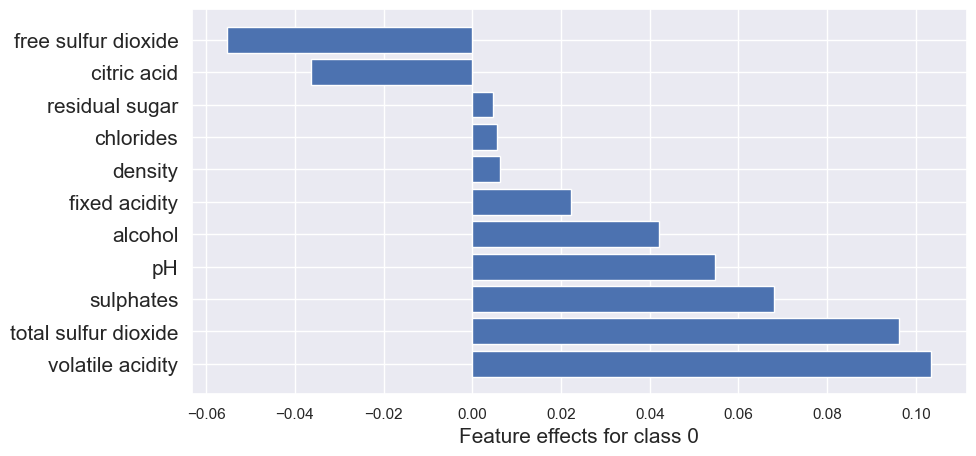

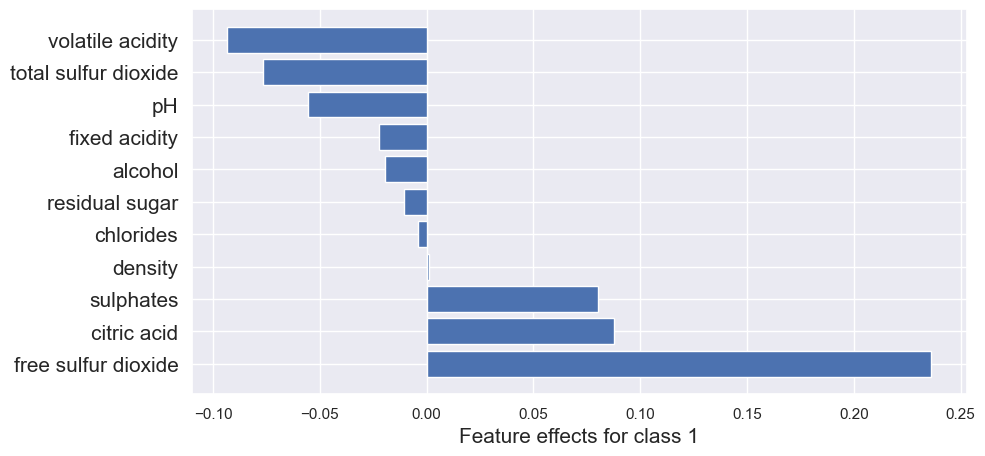

In [41]:
from alibi.explainers import KernelShap
predict_fn = lambda x: model.predict(scaler.transform(x))
explainer = KernelShap(predict_fn, task='classification')
explainer.fit(X_train[0:100])
result_x = explainer.explain(x)
result_cem_cf = explainer.explain(cem_cf)
plot_importance(result_x.shap_values[0], features, 0)
plot_importance(result_cem_cf.shap_values[1], features, 1)

In [42]:
from alibi.explainers import CounterfactualProto
explainer = CounterfactualProto(
model, # The model to explain
shape=(1,) + X_train.shape[1:], # shape of the model input
ae_model=ae, # The autoencoder
enc_model=ae.encoder # The encoder
)
explainer.fit(scaler.transform(X_train)) # Fit the explainer with scaled data
result_proto = explainer.explain(scaler.transform(x), verbose=False)
proto_cf = result_proto.data['cf']['X']
print("Instance class prediction:", model.predict(scaler.transform(x))[0].argmax())
print("Counterfactual class prediction:", model.predict(proto_cf)[0].argmax())

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Instance class prediction: 0
Counterfactual class prediction: 1


In [43]:
proto_cf = scaler.inverse_transform(proto_cf)
compare_instances(x, proto_cf)

fixed acidity             instance:    9.2     counter factual:    9.2     difference: -0.0 
volatile acidity          instance:    0.36    counter factual:    0.36    difference:  0.0 
citric acid               instance:    0.34    counter factual:    0.34    difference:  0.0 
residual sugar            instance:    1.6     counter factual:    1.6     difference: -0.0 
chlorides                 instance:   0.062    counter factual:   0.062    difference: -0.0 
free sulfur dioxide       instance:    5.0     counter factual:    5.0     difference:  0.0 
total sulfur dioxide      instance:    12.0    counter factual:    12.0    difference: -0.0 
density                   instance:   0.997    counter factual:   0.997    difference:  0.0 
pH                        instance:    3.2     counter factual:    3.2     difference: 0.00012
sulphates                 instance:    0.67    counter factual:    0.52    difference: -0.14998
alcohol                   instance:    10.5    counter factual:  

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0.31137032292783273


(<AxesSubplot: xlabel='Feature effects for class 1'>,
 <Figure size 1000x500 with 1 Axes>)

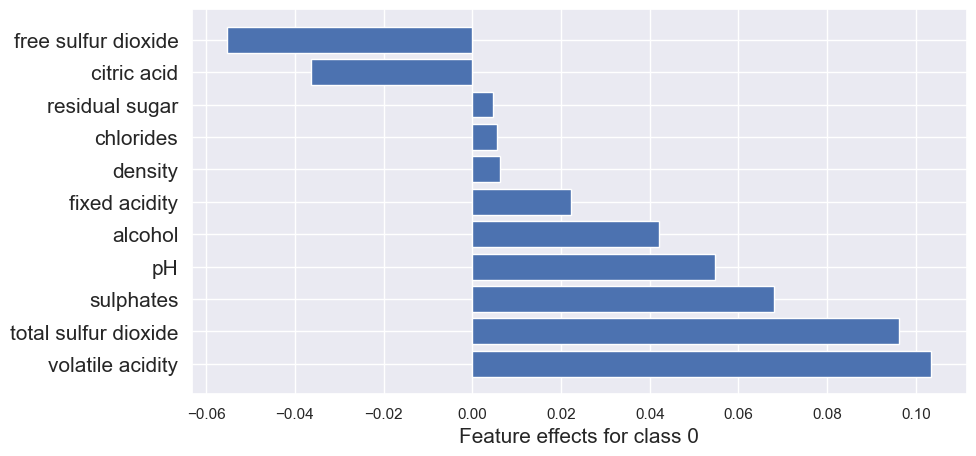

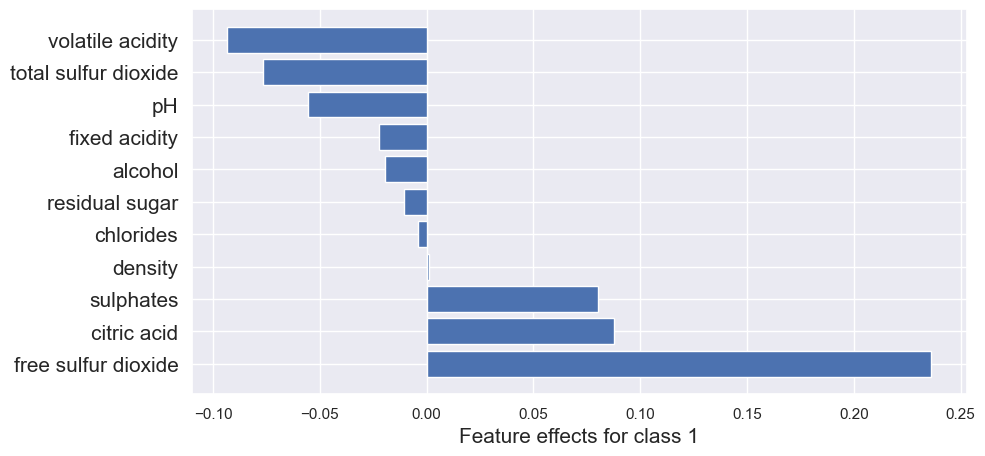

In [46]:
from alibi.explainers import KernelShap
predict_fn = lambda x: model.predict(scaler.transform(x))
explainer = KernelShap(predict_fn, task='classification')
explainer.fit(X_train[0:100])
result_x = explainer.explain(x)
result_proto_cf = explainer.explain(cem_cf)
plot_importance(result_x.shap_values[0], features, 0)
print(result_x.shap_values[0].sum())
plot_importance(result_proto_cf.shap_values[1], features, 1)